## Introduction.

I derived the Black-Scholes formula for European style vanilla FX options in a previous post [here](https://quantophile.github.io/mathsummaries/post/2023/11/19/garman-kohlhagen-for-european-vanilla-fx-options/). The Black-Scholes model $Bl(S_0,K,T,r_{DOM},r_{FOR},\sigma)$ equipped with a single flat volatility parameter $\sigma$ produces option prices which are **NOT consistent** with the observed market prices of FX options across different strikes and maturities. 

Although, the BS model suffers many flaws, it is still often used, at least for quoting purposes. Since all of the other inputs into the model - market data variables such as the stock price $S_0$, the domestic depo rate $r_{DOM}$, the foreign depo rate $r_{FOR}$, and the parameters such as option strike $K$, the time-to-maturity $T$, can be either seen in the market or are known constants, we can easily solve for the value $\sigma_{\text{imp}}$ of the parameter $\sigma$ such that:

$$Bl(S_0,K,T,r_{DOM},r_{FOR},\sigma_{\text{imp}}) = V_{\text{market}}$$

This value $\sigma_{\text{imp}}$ implied from the market price of the option is called the **implied volatility**. 

Thus, although the BS model suffers from flaws, it is mainly used as a quote converter. In the FX options market, option prices are quoted in terms of implied volatilities. The BS formula is used to convert implied vols $\sigma_{\text{imp}}$ to prices and vice versa. The delta hedge to be exchanged between counterparties is calculated according to the BS formula, and this is also true for the Vega hedge of various exotic options. In many cases, the model is also used to run trading books. 

Market conventions used in the FX markets are usually specified in terms of the price and vol attributes of options with various delta characteristics. So, it's nice to explore the intricacies of various types of FX delta and how they are used in the description of market volatility surfaces. The entire concept of the FX volatility smile is based on the parametrization with respect to delta. 

I walk-through the various market conventions used in practice.

## Quote style conversions.

In FX markets, options are quoted in one of 4 quote styles - domestic per foreign (d/f), percentage foreign (%f), percentage domestic (%d) and foreign per domestic (f/d). 

The standard Black-Scholes formula is:

$$
\begin{align}
V_{d/f} &= \omega [S_0 e^{-r_{FOR} T} \Phi(d_{+}) - K e^{-r_{DOM}T} \Phi(d_{-})\\
&= \omega e^{-r_{DOM}T}[F \Phi(d_{+}) - K  \Phi(d_{-})]
\end{align}
$$

Whether a call or a put, it is an option to exchange $K$ units of the domestic currency for $1$ unit of the foreign currency, valued in domestic currency - so it is the domestic/foreign price. 

If we want to express the above as a CCY1/CCY1 price, the conversion is easy : we just take the CCY2/CCY1 price above and convert the CCY2 value into CCY1 terms using today's spot rate $S_0$:

$$
V_{\text{% f}} = \frac{\omega}{S_0}e^{-r_{DOM}T}[F\Phi(\omega d_{+}) - K\Phi(\omega d_{-})] = \frac{V_{d/f}}{S_0}
$$

For the %CCY2 price, we start with the CCY2/CCY1 price, this being the price in CCY2 of an option with a unit notional in the foreign currency. Since the strike is predetermined, it is also the price in CCY2 of an option with a notional of $K$ in CCY2. So, the CCY1/CCY2 price divided by $K$, is the $%ccy2$ price i.e. the percentage domestic price:

$$V_{\%d} = \frac{\omega}{K} e^{-r_{DOM}T}[F \Phi(d_{+}) - K e^{-r_{DOM}T} \Phi(d_{-})] = \frac{V_{d/f}}{K}$$

The ccy1/ccy2 price is the price you need to pay in foreign currency for an option on $1$ unit notional of the domestic currency.

$$V_{f/d} = \frac{V_{\% d}}{S_0} = \frac{V_{d/f}}{S_0 K}$$

The four prices above are relative to the notionals of $K$ in the domestic currency and $1$ in the foreign currency. If the actual notionals are $N_d$ and $N_f$ in domestic and foreign currencies where $N_d = K \cdot N_f$, then we scale accordingly.

#### Implementing the analytic BS-formula

In [144]:
# Author. Quasar C.
# Date. 19-11-2023

import numpy as np
from scipy.stats import norm

# An FX option is the right to exchange 1 unit notional of the foreign currency for K units of the domestic currency at time T. 

class CallPut(Enum):
    CALL_OPTION = 1
    PUT_OPTION = -1
        
def atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma):
    foreignDF = np.exp(-r_FOR*(T-t))
    domesticDF = np.exp(-r_DOM*(T-t))
    fwdPoints = foreignDF / domesticDF
    F = fwdPoints * S_t
    return F
        
def dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return (np.log(F/K) + (T-t)*(sigma**2)/2)/(sigma * np.sqrt(T - t))

def dMinus(S_t,K,t,T,r_DOM,r_FOR,sigma):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return (np.log(F/K) - (T-t)*(sigma**2)/2)/(sigma * np.sqrt(T - t))

def PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    d_minus = dMinus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    domesticDF = np.exp(-r_DOM*(T-t))
    
    undiscountedPrice = omega* (F * norm.cdf(omega * d_plus) - K * norm.cdf(omega * d_minus))
    pv = domesticDF * undiscountedPrice * CCY1Notional
    return pv

#### Computing the ATM-Forward and the option price

In [135]:
S_t=1.40 ; K=1.45 ; t=0.0 ;T=1.0 ; r_DOM=0.04 ; r_FOR=0.06 ; sigma=0.08 ; CCY1Notional=1.00

ATMForward = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)

call_price = PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
put_price = PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)

In [136]:
print(f"At the money forward = {ATMForward} USD")
print(f"Call Price = {call_price} USD")
print(f"Put Price = {put_price} USD")

At the money forward = 1.3722781426294575 USD
Call Price = 0.01578455115811581 USD
Put Price = 0.09045889091103623 USD


#### Plotting the option price against the CCY1CCY2 spot

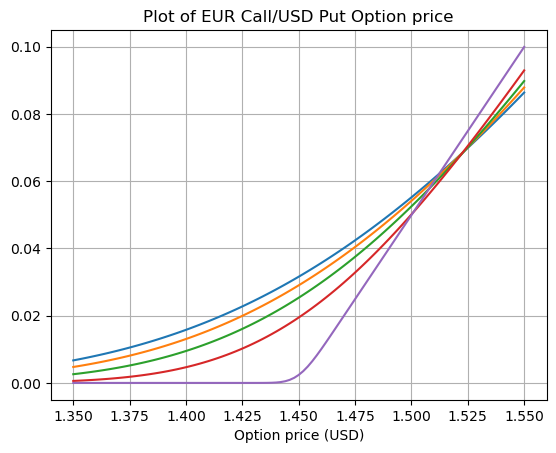

In [142]:
import matplotlib.pyplot as plt

plt.grid(True)
plt.title('Plot of EUR Call/USD Put Option price')
S_t = np.linspace(1.35,1.55,101)
call_price_1y = PV(S_t,K,t,1.0,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
call_price_9m = PV(S_t,K,t,0.75,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
call_price_6m = PV(S_t,K,t,0.50,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
call_price_3m = PV(S_t,K,t,0.25,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
call_price_1d = PV(S_t,K,t,(1.0/365.00),r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)

plt.xlabel(r'EURUSD FX spot')
plt.xlabel(r'Option price (USD)')
plt.plot(S_t,call_price_1y)
plt.plot(S_t,call_price_9m)
plt.plot(S_t,call_price_6m)
plt.plot(S_t,call_price_3m)
plt.plot(S_t,call_price_1d)

plt.show()


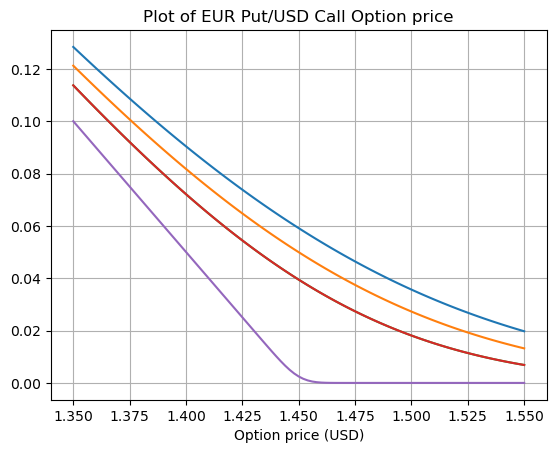

In [143]:
plt.close()

plt.grid(True)
plt.title('Plot of EUR Put/USD Call Option price')

put_price_1y = PV(S_t,K,t,1.0,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)
put_price_9m = PV(S_t,K,t,0.75,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)
put_price_6m = PV(S_t,K,t,0.50,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)
put_price_3m = PV(S_t,K,t,0.50,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)
put_price_1d = PV(S_t,K,t,1/365,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)

plt.xlabel(r'EURUSD FX spot')
plt.xlabel(r'Option price (USD)')

plt.plot(S_t,put_price_1y)
plt.plot(S_t,put_price_9m)
plt.plot(S_t,put_price_6m)
plt.plot(S_t,put_price_3m)
plt.plot(S_t,put_price_1d)
plt.show()

## Option Greeks.

To derive the deltas, we use the following propositions, which are really easy to prove.

***Proposition.*** 

$$\frac{\partial d_{+}}{\partial S_0} = \frac{\partial d_{-}}{\partial S_0} = \frac{1}{\sigma S_0 \sqrt{T}}$$


***Proof***.

We have:

$$
\begin{align*}
d_{\pm} &= \frac{\log {S_0}}{\sigma \sqrt{T}} - \frac{\log {K} + (r \pm \sigma^2/2)T}{\sigma \sqrt{T}}\\
\frac{\partial d_{\pm}}{\partial S_0}&= \frac{1}{\sigma\sqrt{T}}\frac{1}{S_0}
\end{align*}
$$

***Proposition.***

$$\frac{\partial \Phi(\omega d_{\pm})}{\partial S_0} = \frac{\omega}{\sigma S_0 \sqrt{T}}\phi(\omega d_{\pm})$$

***Proof.***

By chain rule, we have:

$$
\begin{align*}
\frac{\partial\Phi(\omega d_{\pm})}{\partial S_0} &= \phi(\omega d_{\pm}) \frac{\partial (\omega d_{\pm})}{dS_0} \\
&= \phi(\omega d_{\pm}) \frac{\omega}{\sigma S_0 \sqrt{T}}
\end{align*}
$$

***Proposition***. The following general result holds:

$$\phi(\omega d_{+}) = \phi(\omega d_{-})\exp(\omega^2 [r_{FOR} - r_{DOM}]T)(K/S_0)^{\omega^2}$$

***Proof.***

We have:

$$
d_{+} + d_{-} = 2 \frac{\log (S_0/K) + (r_{FOR} - r_{DOM})T}{\sigma \sqrt{T}}
$$

$$
d_{+} - d_{-} = \sigma\sqrt{T}
$$

$$
\begin{align*}
\frac{\phi(\omega d_{+})}{\phi(\omega d_{-})} &= \exp\left[-\omega^2\left(\frac{d_{+}^2-d_{-}^2}{2}\right)\right]\\
&= \exp\left[-\omega^2(\log (S_0/K) + (r_{DOM} - r_{FOR})T)\right]\\
&= \exp\left[\omega^2((r_{FOR} - r_{DOM})T)\right](K/S_0)^{\omega^2}
\end{align*}
$$

### Pips Spot Delta

The pips spot delta is simply the derivative of the option price with respect to the spot rate - both expressed in ccy2/ccy1 terms.

$$\Delta_{S;\text{pips}} = \frac{\partial V_{d;\text{pips}}}{\partial S_0}$$

Thus,

$$
\begin{align*}
\frac{\partial V_{\text{d;pips}}}{\partial S_0} &= \omega\frac{\partial }{\partial S_0} \left[(S_0 e^{-r_{FOR}T} \Phi(\omega d_{+}) - K e^{-r_{DOM}T}\Phi(\omega d_{-})\right)]\\
&= \omega \left[e^{-r_{FOR}T} \Phi(\omega d_{+}) + S_0 e^{-r_{FOR}T} \phi (\omega d_{+})\frac{\omega}{\sigma S_0 \sqrt{T}} - K e^{-r_{DOM}T}\phi (\omega d_{-})\frac{\omega}{\sigma S_0 \sqrt{T}}\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[S_0 e^{-r_{FOR}T} \phi(\omega d_{+}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[S_0 e^{-r_{FOR}T} e^{(r_{FOR} - r_{DOM})T}\frac{K}{S_0}\phi(\omega d_{-}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[K e^{-r_{DOM}T}\phi(\omega d_{-}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+})
\end{align*}
$$

If we think of a delta hedge, it is just the number of units of foreign currency we need to hold in order to hedge an option with a notional of 1 unit of foreign currency and an equivalent notional of $K$ units of domestic currency. So, the spot delta is expressed as a percentage of the foreign currency.

#### Implementing Analytic Delta.

In [149]:
def analyticDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION):
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return omega * np.exp(-r_FOR * (T-t)) * norm.cdf(omega * d_plus) * CCY1Notional

In [159]:
S_t=1.40 ; K=1.45 ; t=0.0 ;T=1.0 ; r_DOM=0.04 ; r_FOR=0.06 ; sigma=0.08 ; CCY1Notional=1.00

pips_spot_delta = analyticDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
print(f"Spot Delta = {pips_spot_delta} EUR")

Spot Delta = 0.24324371203694523 EUR


#### Plotting the Analytic Delta of call options

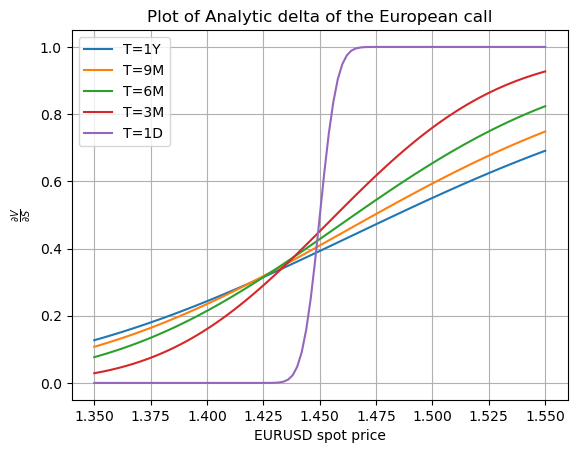

In [167]:
plt.close()

plt.grid(True)
plt.title('Plot of Analytic delta of the European call')
plt.xlabel('EURUSD spot price')
plt.ylabel(r'$\frac{\partial V}{\partial S}$')

S_t = np.linspace(1.35,1.55,101)
delta = analyticDelta(S_t,K,t,1.0,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=1Y')
delta = analyticDelta(S_t,K,t,0.75,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=9M')
delta = analyticDelta(S_t,K,t,0.50,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=6M')
delta = analyticDelta(S_t,K,t,0.25,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=3M')
delta = analyticDelta(S_t,K,t,1/365.0,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=1D')
plt.legend(loc="upper left")
plt.show()

### Forward Delta

The interpretation of the foward delta is the number of units of FOR of forward contracts a trader needs to buy to delta hedge a short option position. 

